# Setup

### Imports

In [1]:
# built-ins
import os
import json
import math
import time
import pickle
import traceback
import time
from os import path
from pathlib import Path
from datetime import datetime
from copy import deepcopy
from functools import partial
from itertools import combinations

# common
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# misc
from IPython.display import display, clear_output, Markdown
from termcolor import colored

# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.decomposition import PCA

# metrics
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from scipy.stats import ttest_ind

# training
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier

### Initial tasks

In [2]:
# allow multiple outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# suppress warnings
import sys, os, warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# also suppress warnings of parallel processes such as grid search cv
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses
    
# configure pandas
pd.set_option("display.max_columns", None)

### Utils / Helpers

In [3]:
def enum(*sequential, **named):
    enums = dict(zip(sequential, range(len(sequential))), **named)
    return type('Enum', (), enums)

In [4]:
def merge(a, b):
    return {**a, **b}

def cprint(text, color):
    print(colored(text, color, attrs=['bold']))
    
def print_red(text):
    cprint(text, 'red')

def print_blue(text):
    cprint(text, 'blue')
    
def print_dim(text):
    print(colored(text, 'grey'))

In [5]:
class Time(object):
    def __enter__(self):
        self.start_time = time.time()
  
    def __exit__(self, *args, **kwargs):
        print("--- took %.2f seconds ---" % (time.time() - self.start_time))

In [6]:
class Output:
    class printer(str):
        def __repr__(self):
            return self
    
    def __init__(self):
        self.out = None
    
    def update(self, output):
        output = self.printer(output)
        
        if self.out is None:
            self.out = display(output, display_id=True)
        else:
            self.out.update(output)

In [7]:
class PrintDuration(object):
    class printer(str):
        def __repr__(self):
            return self
        
    def __enter__(self):
        self.start_time = datetime.now()
        self.last_tick = self.start_time
        self.tick_count = 0
        self.tick_times = 0
        
        self.completed = False
        self.progress = 0
        self.ert = 0
        self.att = 0
        self.out = None
        
        return self.tick
  
    def __exit__(self, exc_type, exc_value, tb):
        if exc_type is not None:
            traceback.print_exception(exc_type, exc_value, tb)
        
        self.completed = True
        self.render()
        
    def tdformat(self, seconds):
        hours, remainder = divmod(seconds, 3600)
        minutes, seconds = divmod(remainder, 60)
        return '{:02}:{:02}:{:02}'.format(int(hours), int(minutes), int(seconds))
    
    def render(self):
        output = ''
        
        if self.completed:
            complete_time = (datetime.now() - self.start_time).total_seconds()
            complete_time = self.tdformat(complete_time)
            output = f'100% completed, total run time = {complete_time}'
        else:
            percent = round(self.progress * 100)
            att = self.tdformat(self.att)
            ert = self.tdformat(self.ert)
            output = f'{percent}% completed, remaining time = {ert}, avg ticktime = {att}'
        
        output = self.printer(output)
        
        if self.out is None:
            self.out = display(output, display_id=True)
        else:
            self.out.update(output)
    
    def tick(self, progress):
        now = datetime.now()
        
        # calculate
        work_time = (now - self.start_time).total_seconds()
        tick_time = (now - self.last_tick).total_seconds()
        self.tick_count += 1
        self.tick_times += tick_time
        avg_tick_time = self.tick_times // self.tick_count
        
        if progress > 0:
            total_ticks = self.tick_count // progress
            remained_ticks = total_ticks - self.tick_count
            est_remain_time = avg_tick_time * remained_ticks
        else:
            est_remain_time = 0
            
        # set
        self.progress = progress
        self.att = avg_tick_time
        self.ert = est_remain_time
        
        # render
        self.render() 

### Detect Env

In [8]:
ENV_KAGGLE = os.environ.get('KAGGLE_KERNEL_RUN_TYPE') is not None

### Path Definitions

In [9]:
PATH_ROOT = '.'
PATH_DATASET = path.join(PATH_ROOT, 'dataset')
PATH_CSV = path.join(PATH_DATASET, 'csv')
PATH_MODELS = path.join(PATH_ROOT, 'models')

if ENV_KAGGLE:
    PATH_ROOT = '/kaggle/working'
    PATH_DATASET = '/kaggle/input/personal-key-indicators-of-heart-disease'
    PATH_CSV = PATH_DATASET
    PATH_MODELS = path.join(PATH_ROOT, 'models')
    
# Create directories.
Path(PATH_MODELS).mkdir(parents=True, exist_ok=True)

### Constants

In [10]:
TARGET_COLUMN = 'HeartDisease'
TARGET_CLASSES = ('No', 'Yes')
TARGET = (TARGET_COLUMN, TARGET_CLASSES)

PARAM_STRATEGY = enum('HP_TUNING', 'DEFAULTS', 'PREDEFINED')
HP_TUNER = enum('GRID_SEARCH', 'RANDOM_SEARCH')

### Configs

In [11]:
CFG_CSV_NAME = 'data.csv'

if ENV_KAGGLE:
    CFG_CSV_NAME = 'heart_2020_cleaned.csv'

# Hyperparameters

In [12]:
HP_SCORING = ('moved', 'f1', 1)
HP_SEED = 339
HP_CV_SPLITS = (10, 5)
HP_TEST_SIZE = 0.2

# Import Dataset

In [13]:
# read csv
data = pd.read_csv(path.join(PATH_CSV, CFG_CSV_NAME), encoding='utf-8')

# drop duplicates
data = data.drop_duplicates().reset_index(drop=True)

### Limit Data

In [14]:
# limit data helper
def use_limited_data(data, limit):
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=limit, random_state=HP_SEED)
    _, test_index = next(iter(splitter.split(data, data[TARGET_COLUMN])))
    return data.loc[test_index].reset_index(drop=True)

# always keep full data
full_data = data

# use limited data (for local tests)
data = use_limited_data(full_data, round(len(full_data) * 0.1)) # percent

### Simple EDA

In [15]:
data.shape
data.info()

(30172, 18)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30172 entries, 0 to 30171
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HeartDisease      30172 non-null  object 
 1   BMI               30172 non-null  float64
 2   Smoking           30172 non-null  object 
 3   AlcoholDrinking   30172 non-null  object 
 4   Stroke            30172 non-null  object 
 5   PhysicalHealth    30172 non-null  float64
 6   MentalHealth      30172 non-null  float64
 7   DiffWalking       30172 non-null  object 
 8   Sex               30172 non-null  object 
 9   AgeCategory       30172 non-null  object 
 10  Race              30172 non-null  object 
 11  Diabetic          30172 non-null  object 
 12  PhysicalActivity  30172 non-null  object 
 13  GenHealth         30172 non-null  object 
 14  SleepTime         30172 non-null  float64
 15  Asthma            30172 non-null  object 
 16  KidneyDisease     30172 non-null  object

In [16]:
data.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,28.95,Yes,No,No,0.0,30.0,Yes,Male,50-54,White,No,No,Fair,18.0,No,No,No
1,No,30.67,No,No,No,7.0,0.0,No,Female,65-69,Black,No,No,Good,6.0,No,No,No
2,No,20.92,No,No,No,0.0,0.0,No,Male,18-24,Black,No,Yes,Excellent,8.0,No,No,No
3,No,21.70,No,No,No,0.0,10.0,No,Male,18-24,White,No,Yes,Excellent,7.0,No,No,No
4,No,32.49,Yes,No,No,2.0,0.0,Yes,Male,25-29,Hispanic,No,No,Very good,8.0,No,No,No


In [17]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
BMI,30172.0,28.479467,6.549344,12.13,24.03,27.41,31.75,93.97
PhysicalHealth,30172.0,3.592205,8.195153,0.00,0.00,0.00,2.00,30.00
MentalHealth,30172.0,4.122531,8.151030,0.00,0.00,0.00,4.00,30.00
SleepTime,30172.0,7.075302,1.470320,1.00,6.00,7.00,8.00,24.00


In [18]:
data.isnull().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

In [19]:
data.nunique()

HeartDisease           2
BMI                 2098
Smoking                2
AlcoholDrinking        2
Stroke                 2
PhysicalHealth        31
MentalHealth          31
DiffWalking            2
Sex                    2
AgeCategory           13
Race                   6
Diabetic               4
PhysicalActivity       2
GenHealth              5
SleepTime             22
Asthma                 2
KidneyDisease          2
SkinCancer             2
dtype: int64

In [20]:
categorical_columns = data.select_dtypes(exclude=['float64']).columns

for col in categorical_columns:
    col = data[col]
    pd.concat([col.value_counts(normalize=True), col.value_counts()], axis=1)

,HeartDisease,HeartDisease
No,0.909651,27446
Yes,0.090349,2726


,Smoking,Smoking
No,0.573081,17291
Yes,0.426919,12881


,AlcoholDrinking,AlcoholDrinking
No,0.927383,27981
Yes,0.072617,2191


,Stroke,Stroke
No,0.961786,29019
Yes,0.038214,1153


,DiffWalking,DiffWalking
No,0.851385,25688
Yes,0.148615,4484


,Sex,Sex
Female,0.526846,15896
Male,0.473154,14276


,AgeCategory,AgeCategory
65-69,0.106721,3220
60-64,0.101551,3064
70-74,0.095386,2878
55-59,0.093033,2807
50-54,0.078583,2371
80 or older,0.078086,2356
45-49,0.070496,2127
75-79,0.068076,2054
40-44,0.066552,2008
18-24,0.066419,2004


,Race,Race
White,0.758849,22896
Hispanic,0.088758,2678
Black,0.071755,2165
Other,0.036292,1095
Asian,0.026747,807
American Indian/Alaskan Native,0.017599,531


,Diabetic,Diabetic
No,0.836173,25229
Yes,0.135258,4081
"No, borderline diabetes",0.021576,651
Yes (during pregnancy),0.006993,211


,PhysicalActivity,PhysicalActivity
Yes,0.764649,23071
No,0.235351,7101


,GenHealth,GenHealth
Very good,0.345188,10415
Good,0.302201,9118
Excellent,0.197070,5946
Fair,0.116366,3511
Poor,0.039175,1182


,Asthma,Asthma
No,0.856059,25829
Yes,0.143941,4343


,KidneyDisease,KidneyDisease
No,0.960261,28973
Yes,0.039739,1199


,SkinCancer,SkinCancer
No,0.902459,27229
Yes,0.097541,2943


# Pipeline Setup

## Sampler

In [21]:
def sample(N, data, target, classes, indexes):
    N = list(N)

    # separate data
    test_index, train_index = indexes
    test = data.loc[test_index]
    train = data.loc[train_index]

    # calculate sizes
    sizes = [sum(train[target] == c) for c in classes] 

    # fix sizes
    for i, n in enumerate(N):
        if type(n) is float:
            N[i] = round(N[i] * sizes[i])

    # do sampling
    groups = [train[train[target] == c] for c in classes] 
    samples = [group.sample(N[i], replace=(sizes[i] < N[i])) for i, group in enumerate(groups)]
    
    # calculate final sizes
    train_size = sum(N)
    test_size = len(test_index)
    
    # calculate next indexes
    train_index = list(range(train_size))
    test_index = list(range(train_size, train_size + test_size))
    
    # create shuffled train dataframe
    samples = pd.concat(samples, axis=0).sample(frac=1).reset_index(drop=True)
    
    # concatenate data
    data = pd.concat([samples, test], axis=0).reset_index(drop=True)
    
    # return data and indexes
    return data, test_index, train_index

## Preprocessor

In [22]:
class OutlierRemover:
    @staticmethod
    def numeric(data):
        cols = data.select_dtypes(include=['float64', 'int64']).columns.to_list()
        return OutlierRemover(cols)
    
    def __init__(self, cols):
        self.cols = cols
        self.bands = {}
    
    def fit(self, data):
        for col in self.cols:
            Q1 = data[col].quantile(0.25)
            Q3 = data[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_band = Q1 - 1.5 * IQR
            upper_band = Q3 + 1.5 * IQR
            
            self.bands[col] = (lower_band, upper_band)
    
    def transform(self, data):
        for col in self.cols:
            lower_band, upper_band = self.bands[col]
            inliers = ~((data[col] < lower_band) | (data[col] > upper_band))
            data = data[inliers]
            
        return data
            
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)
    
class MultiLabelEncoder():
    @staticmethod
    def binary(data):
        cols = [col for col in data.columns if data[col].nunique() == 2]
        return MultiLabelEncoder(cols)
    
    def __init__(self, cols):
        self.cols = cols
        self.encoders = {col: LabelEncoder() for col in cols}
    
    def fit(self, data):
        for col in self.cols:
            self.encoders[col].fit(data[col])

    def transform(self, data):
        for col in self.cols:
            data[col] = self.encoders[col].transform(data[col])
        
        return data
    
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

class Preprocessor:
    @staticmethod
    def params(override={}):
        defaults = {
            'target': 'HeartDisease',
            'outlier_strategy': 'all',
            'encode_labels': True,
            'pca': False,
            'onehot_encoding': ['Race', 'Diabetic'],
            'ordinal_encoding': {
                'GenHealth': ['Poor', 'Fair', 'Good', 'Very good','Excellent'],
                'AgeCategory': ['18-24', '25-29','30-34', '35-39', '40-44', '45-49', '50-54',
                                '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older']
            }
        }

        return merge(defaults, override)
    
    @staticmethod
    def process(*args, **kwargs):
        processor = Preprocessor(*args, **kwargs)
        processor.apply()
        return processor
    
    def __init__(self, data, test_index=None, train_index=None, options=None):
        if options is None:
            options = Preprocessor.params()
        
        if train_index is None:
            train_index = list(range(len(data)))
            test_index = []
        
        self.data = data
        self.test_index = np.array(test_index)
        self.train_index = np.array(train_index)
        self.options = options
        
        self.target = self.options['target']
        self.update_meta()
    
    def update_meta(self):
        self.features_mask = self.data.columns != self.target
        self.columns = self.data.columns
        self.feature_columns = self.columns[self.features_mask]
        self.has_train = self.train_index.shape[0] > 0
        self.has_test = self.test_index.shape[0] > 0

    def override_data(self, value):
        labels = self.y
        self.data = pd.DataFrame(data=value, index=self.data.index)
        self.data[self.target] = labels
        self.update_meta()
            
    def get_x(self, df):
        return df.drop(self.target, axis=1).to_numpy()
    
    def get_y(self, df):
        return df[self.target].to_numpy()
    
    # .x getter/setter
    @property
    def x(self):
        return self.get_x(self.data)
    
    @x.setter
    def x(self, value):
        self.data.loc[:, self.features_mask] = value
        
    # .y getter/setter
    @property
    def y(self):
        return self.get_y(self.data)
    
    @y.setter
    def y(self, value):
        self.data.loc[:, [self.target]] = value
    
    # .test getter/setter
    @property
    def test(self):
        return self.data.loc[self.test_index]
    
    @test.setter
    def test(self, value):
        self.data.loc[self.test_index] = value
    
    # .train getter/setter
    @property
    def train(self):
        return self.data.loc[self.train_index]
    
    @train.setter
    def train(self, value):
        self.data.loc[self.train_index] = value
    
    # .x_test getter/setter
    @property
    def x_test(self):
        return self.get_x(self.test)
    
    @x_test.setter
    def x_test(self, value):
        self.data.loc[self.test_index, self.features_mask] = value
        
    # .x_train getter/setter
    @property
    def x_train(self):
        return self.get_x(self.train)
    
    @x_train.setter
    def x_train(self, value):
        self.data.loc[self.train_index, self.features_mask] = value
    
    # .y_test getter
    @property
    def y_test(self):
        return self.get_y(self.test)
        
    # .y_test setter
    @property
    def y_train(self):
        return self.get_y(self.train)
    
    def chop(self):
        return self.x_test, self.y_test, self.x_train, self.y_train
    
    def apply(self):
        # remove outliers
        outlier_strategy = self.options.get('outlier_strategy', 'train_only')
        outlier_remover = OutlierRemover.numeric(self.data)
        if outlier_strategy == 'train_only':
            self.train = outlier_remover.fit_transform(self.train)
        elif outlier_strategy == 'include_test':
            outlier_remover.fit(self.train())
            self.data = outlier_remover.transform(self.data)
        elif outlier_strategy == 'all':
            self.data = outlier_remover.fit_transform(self.data)
        else:
            pass
        
        # update removed indexes.
        indexes = self.data.index.values
        self.train_index = self.train_index[np.isin(self.train_index, indexes)]
        self.test_index = self.test_index[np.isin(self.test_index, indexes)]
        
        # encode labels
        encode_labels = self.options.get('encode_labels', True)
        if encode_labels:
            self.data = MultiLabelEncoder.binary(self.data).fit_transform(self.data)
            
        onehot_encoding = self.options.get('onehot_encoding', None)
        if onehot_encoding is not None:
            cols = onehot_encoding
            self.data = pd.get_dummies(self.data, columns=cols, prefix=cols)
            self.update_meta()
            
        # ordinal encoding
        ordinal_encoding = self.options.get('ordinal_encoding', None)
        if ordinal_encoding is not None:
            for col, ordinals in ordinal_encoding.items():
                encoder = OrdinalEncoder(categories=[ordinals])
                self.data[[col]] = encoder.fit_transform(self.data[[col]])
        
        # scaler
        scale = self.options.get('scale', True)
        if scale:
            scaler = StandardScaler()
            self.x_train = scaler.fit_transform(self.x_train)
            
            if self.has_test:
                self.x_test = scaler.transform(self.x_test)
                
        # PCA
        pca_n = self.options.get('pca', False)
        if pca_n:
            pca = PCA(n_components=pca_n, svd_solver='full', copy=True)
            pca.fit(self.x_train)
            result = pca.transform(self.x)
            self.override_data(result)

## Model

In [23]:
class Model:
    def __init__(self, estimator, data, target, scoring, n_splits, test_size, seed,
                 sampling=None, prep_params=None, hp_grid=None, hp_tuner=HP_TUNER.RANDOM_SEARCH):
        
        self.estimator = estimator
        self.data = data
        self.target = target
        self.scoring = scoring
        self.n_splits = n_splits
        self.test_size = test_size
        self.seed = seed
        self.sampling = sampling
        self.prep_params = prep_params
        self.hp_grid = hp_grid
        self.hp_tuner = hp_tuner

        self.trained = False
        self.scores = {}
        self.results = []
        self.best_result = None
        
        self.parse_args()
    
    def parse_args(self):
        self.n_test_split, self.n_grid_split = self.n_splits
        
        self.score_type, self.score_fn, self.score_cls = self.scoring
        
        self.target_column, self.target_classes = self.target
        self.target_encoded_classes = list(range(len(self.target_classes)))
    
    @property
    def model(self):
        return self.best_result['model']
    
    @property
    def preprocessor(self):
        return self.best_result['preprocessor']
    
    @property
    def score(self):
        return self.scores[self.score_type][self.score_fn]
    
    def split(self):
        split = StratifiedShuffleSplit(n_splits=self.n_test_split, test_size=self.test_size, random_state=self.seed)
        return split.split(self.data, self.data[self.target_column])
    
    def train(self, tick=None):
        for split_index, (train_index, test_index) in enumerate(self.split()):
            if tick is not None:
                tick(split_index/self.n_test_split)
            
            # get values
            data = self.data
            sampling = self.sampling
            target_column = self.target_column
            target_classes = self.target_classes
            
            # default values
            best_params = None
            best_estimator = None
            
            # do sampling
            if sampling is not None:
                # set sample sizes
                sample_sizes = sampling

                # if function
                if callable(sampling):
                    train_data = data.loc[train_index]
                    sample_sizes = sampling(train_data)

                # sample data
                data, test_index, train_index = sample(sample_sizes, data, target_column, target_classes, (test_index, train_index))
            
            # preprocess data
            preprocessor = Preprocessor.process(data, test_index, train_index, self.prep_params)
            X_test, Y_test, X_train, Y_train = preprocessor.chop()
                        
            # fix grid
            is_grid, hp_grid = self.fix_hp_grid(self.hp_grid)
            
            # if given parameters are grid do grid search
            if is_grid:
                tuner_params = {
                    'estimator': self.estimator(), 'cv': self.n_grid_split,
                    'scoring': self.score_fn, 'n_jobs': -1
                }
                
                if self.hp_tuner == HP_TUNER.RANDOM_SEARCH:
                    HPTuner = RandomizedSearchCV
                    tuner_params['param_distributions'] = hp_grid

                if self.hp_tuner == HP_TUNER.GRID_SEARCH:
                    HPTuner = GridSearchCV
                    tuner_params['param_grid'] = hp_grid
                
                # create grid searcher
                gscv = HPTuner(**tuner_params)
                
                # fit
                gscv.fit(X_train, Y_train)
                
                # collect best results
                best_params = gscv.best_params_
                best_estimator = gscv.best_estimator_
            
            # if given parameters are singular or none do direct training.
            else:
                # create and fit estimator
                best_estimator = self.estimator(**hp_grid)
                best_estimator.fit(X_train, Y_train)
                best_params = hp_grid
            
            # get predictions
            Y_pred = best_estimator.predict(X_test)
            Y_prob = best_estimator.predict_proba(X_test)
            
            # create result 
            self.results.append({
                'y_true': Y_test, 'y_pred': Y_pred, 'y_prob': Y_prob, 
                'params': best_params, 'model': best_estimator,
                'preprocessor': preprocessor, 'seed': self.seed,
            })
            
        self._calculate_scores()
        self._set_best_result()
        self._calculate_mean_scores()
        self.trained = True
    
    def fix_hp_grid(self, hp_grid=None):
        if hp_grid is None:
            return False, {}

        # check if there is multidimensional value.
        is_grid = sum([np.ndim(v) for v in hp_grid.values()]) > 0
        
        # fix singular values if suppose to be a grid.
        if is_grid:
            hp_grid = {k: [v] if np.ndim(v) == 0 else v for k, v in hp_grid.items()}

        return is_grid, hp_grid
        
    def _calculate_scores(self):
        classes = self.target_encoded_classes[::-1]

        score_fns = {
            'accuracy': accuracy_score,
            'f1_micro': partial(f1_score, average='micro'),
        }

        metrics = {
            'f1': f1_score,
            'recall': recall_score,
            'precision': precision_score,
        }

        for cls in classes:
            for metric, fn in metrics.items():
                name = metric if cls == self.score_cls else f'{cls}.{metric}'
                score_fns[name] = partial(fn, pos_label=cls)

        # calculate for each result.
        for result in self.results:
            # get targets
            Y_true, Y_pred, Y_prob = result['y_true'], result['y_pred'], result['y_prob']

            # create scores
            scores = result['scores'] = dict(raw={}, moved={})

            # calculate raw scores
            for name, fn in score_fns.items():
                scores['raw'][name] = fn(Y_true, Y_pred)

            # calculate threshold moved scores
            moved_score = -1
            moved_pred = None
            moved_threshold = None

            # find the best threshold
            for threshold in np.arange(0.5, 0, -0.01):
                pred = (Y_prob[:, 1] >= threshold).astype(int)
                score = score_fns[self.score_fn](Y_true, pred)

                if score > moved_score:
                    moved_pred = pred
                    moved_score = score
                    moved_threshold = threshold

            # calculate threshold moved scores
            for name, fn in score_fns.items():
                scores['moved'][name] = fn(Y_true, moved_pred)

            # keep the threshold info
            result['moved_threshold'] = moved_threshold
    
    def _set_best_result(self):
        best_score = -1
        best_result = None
        
        for result in self.results:
            score = result['scores'][self.score_type][self.score_fn]

            if score > best_score:
                best_score = score
                best_result = result
        
        self.best_result = best_result
        
    def _calculate_mean_scores(self):
        scores = self.scores = {}
        result_scores = self.best_result['scores']
        results = self.results
        count = len(results)

        for result in results:
            for group_name, group_scores in result_scores.items():
                scores.setdefault(group_name, {})
                for name, score in group_scores.items():
                    scores[group_name].setdefault(name, 0)
                    scores[group_name][name] += score / count

## Trainer

In [24]:
class Trainer:   
    def __init__(self, name, data, target, scoring, n_splits, test_size, seed, sampling=None, prep_params=None):
        self.name = name
        self.data = data
        self.target = target
        self.scoring = scoring
        self.n_splits = n_splits
        self.test_size = test_size
        self.seed = seed
        self.sampling = sampling
        self.prep_params = prep_params
        
        self.estimators = {}
        self.param_strategy = PARAM_STRATEGY.DEFAULTS
        self.predefined_params = {}
    
    def add_estimator(self, name, estimator, hp_grid=None):
        self.estimators[name] = (name, estimator, hp_grid)
    
    def set_predefined_params(self, params):
        self.predefined_params = params
    
    def use_hp_tuner(self, hp_tuner):
        self.hp_tuner = hp_tuner
    
    def use_param_strategy(self, strategy):
        self.param_strategy = strategy
    
    def get_estimator_params(self, name):
        if self.param_strategy == PARAM_STRATEGY.DEFAULTS:
            return {}
        
        if self.param_strategy == PARAM_STRATEGY.PREDEFINED:
            return self.predefined_params.get(name, {})
        
        if self.param_strategy == PARAM_STRATEGY.HP_TUNING:
            return self.estimators[name][2]
    
    def get_model_path(self, name):
        return path.join(PATH_MODELS, f'{self.name}_{name}.pickle')
    
    def save_model(self, name, model):
        model_path = self.get_model_path(name)
        with open(model_path,'wb') as file:
            pickle.dump(model, file)
        
    def load_model(self, name):
        model_path = self.get_model_path(name)
        with open(model_path, 'rb') as file:
            return pickle.load(file)
        
    def train_estimators(self, **kwargs):
        estimators = kwargs.pop('estimators', self.estimators.keys())
        for name in estimators:
            print_red(f'Estimator: {name}\n')
            model = self.train_estimator(name, **kwargs)
            yield (name, model)
            
    def train_estimator(self, name, reset=False, seed=None, save=True, print_duration=True):      
        if seed is None:
            seed = self.seed
        
        if not reset:
            try:
                model = self.load_model(name)
                setattr(self, name, model)
                
                print(f'Model {name} is loaded from disk successfully.')
                return model
            
            except:
                model = None
        
        name, estimator, _ = self.estimators[name]
        params = self.get_estimator_params(name)

        model = Model(estimator, self.data, self.target, self.scoring, self.n_splits,
                    self.test_size, seed, self.sampling, self.prep_params, params, self.hp_tuner)
        
        if print_duration:
            with PrintDuration() as tick:
                model.train(tick)
        else:
            model.train()
        
        setattr(self, name, model)
        if save:
            self.save_model(name, model)
            
        return model
    
    def search_best_seed(self, name, seed_range=range(100)):
        output = Output()
        
        best_score = -1
        best_seed = 0
        
        print(f'Searching best seed for {name}')
        
        for seed in seed_range:
            output.update(f'  -> Testing seed {seed}')
            model = self.train_estimator(name=name, seed=seed, save=False, print_duration=False)
            score = model.score

            if score > best_score:
                best_score = score
                best_seed = seed
                print(f'* {seed} -> {score}')
        
        print(f'Best seed found as {best_seed}')
        return best_seed

    def calculate_ttest(self, p=0.05):
        models = list(self.estimators.keys())
        score_type, score_fn, _ = self.scoring

        scores = {m: [r['scores'][score_type][score_fn] for r in getattr(self, m).results] for m in models}
        pairs = list(combinations(models, 2))

        ttests = []
        for a, b in pairs:
            t_val, p_val = ttest_ind(scores[a], scores[b])

            ttests.append({
                'models': [a, b], 't_val': abs(t_val),
                'p_val': p_val, 'significant': p_val <= p
            })

        significants = [t['models'] for t in ttests if t['significant']]
        non_significants = [t['models'] for t in ttests if not t['significant']]

        return significants, non_significants, ttests
    
    def get_results_df(self, name, shuffle=False, ascending=False):
        model = getattr(self, name)

        true = model.best_result['y_true'].reshape(-1)
        pred = model.best_result['y_pred'].reshape(-1)
        
        df = pd.DataFrame(data={
            'true': true,
            'prediction': pred,
            'diff': np.absolute(true - pred)
        })
    
        if shuffle:
            df = df.sample(frac=1)
        else:
            df = df.sort_values('diff', ascending=ascending)
        
        return df
    
    def get_scores_df(self, name):
        model = getattr(self, name)
        result = model.best_result

        scores = model.scores
        index = list(scores.keys())
        cols = list(scores[index[0]].keys())
        values = [[val for val in vals.values()] for vals in scores.values()]

        return pd.DataFrame(values, index, cols)

## SetTrainer

In [25]:
class SetTrainer:
    def __init__(self):
        self.estimators = {}
        self.trainer_names = []
        self.param_strategy = PARAM_STRATEGY.HP_TUNING
        
    def add_estimator(self, name, estimator, hp_grid=None):
        self.estimators[name] = (name, estimator, hp_grid)
    
    def add_trainer(self, **kwargs):
        name = kwargs['name']
        trainer = Trainer(**kwargs)
        
        for estimator_name in self.estimators:
            _, estimator, hp_grid = self.estimators[estimator_name]
            hp_grid = deepcopy(hp_grid)
            trainer.add_estimator(estimator_name, estimator, hp_grid)
        
        trainer.use_param_strategy(self.param_strategy)
        trainer.use_hp_tuner(self.hp_tuner)
        
        self.trainer_names.append(name)
        setattr(self, name, trainer)
    
    def use_hp_tuner(self, tuner):
        self.hp_tuner = tuner
    
    def use_param_strategy(self, strategy):
        self.param_strategy = strategy
    
    def run_trainer(self, name, **kwargs):
        trainer = getattr(self, name)
        for (model_name, model) in trainer.train_estimators(**kwargs):
            yield (name, trainer, model_name, model)
            
    def run_all_trainers(self, **kwargs):
        trainers = kwargs.pop('trainers', self.trainer_names)
        count = len(trainers)
        
        for index, name in enumerate(trainers):
            print_blue(f'Trainer {index+1}/{count}: {name}\n')
            for (trainer_name, trainer, model_name, model) in self.run_trainer(name, **kwargs):
                yield (trainer_name, trainer, model_name, model)
                
    def save_scores(self):
        columns = ['trainer', 'model']
        values = []

        score_cols = None

        for trainer_name in self.trainer_names:
            trainer = getattr(self, trainer_name)

            for model_name in trainer.estimators:
                model = getattr(trainer, model_name, None)

                if model is not None and model.trained:
                    value = [trainer_name, model_name[:10]]

                    if score_cols is None:
                        score_cols = [f'{group[:1]}/{fn[:]}' for group in model.scores for fn in model.scores[group]]

                    value += [round(val, 3) for group in model.scores.values() for val in group.values()]
                    values.append(value)

        columns += score_cols

        df = pd.DataFrame(values, columns=columns)
        df.sort_values(by='model', inplace=True)
        df.to_csv(path.join(PATH_MODELS, f'scores.csv'), index=False)
        df.reset_index(drop=True, inplace=True)
        
        return df

## Helper Functions

### Feature Importance

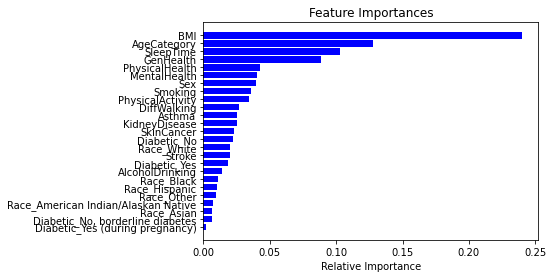

In [26]:
def calculate_feature_importances(data, target, scoring, n_splits, test_size, seed):
    model = Model(RandomForestClassifier, data, target, scoring, n_splits, test_size, seed)
    model.train()
    
    importances = model.model.feature_importances_
    indices = np.argsort(importances)
    graph_x = range(len(indices))
    
    plt.title('Feature Importances')
    plt.barh(graph_x, importances[indices], color='b', align='center')
    plt.yticks(graph_x, model.preprocessor.feature_columns[indices])
    plt.xlabel('Relative Importance')
    plt.show()

data_ = use_limited_data(full_data, 3200)
calculate_feature_importances(data=data_, target=TARGET, scoring=HP_SCORING,
                              n_splits=HP_CV_SPLITS, test_size=HP_TEST_SIZE, seed=HP_SEED)

### Explained Variance Ratio

For p=95% n_components should be 21



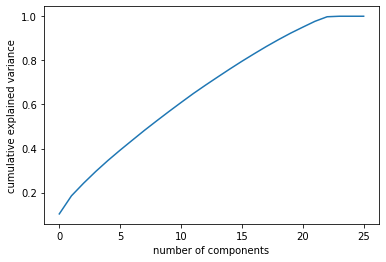

In [27]:
def calculate_explained_variance_ratio(data, p=0.95):
    X = Preprocessor.process(data).data
    
    pca = PCA(n_components=None, svd_solver='full', copy=True)
    reduced = pca.fit_transform(X)
    
    # extract the smallest number of components which
    # explain at least p% (e.g. 80%) of the variance
    n_components = 1 + np.argmax(np.cumsum(pca.explained_variance_ratio_) >= p)
    print(f'For p={int(p*100)}% n_components should be {n_components}\n')

    # extract the values of the selected components
    #Z = pca.transform(X)[:, :n_components]
    
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    
data_ = use_limited_data(full_data, 3200)
calculate_explained_variance_ratio(data_, 0.95)

### Best Seed Calculation

In [28]:
def calculate_best_seed(seed_range, estimators, data, target, scoring, n_splits, test_size):
    trainer = Trainer('trainer', data, target, scoring, n_splits, test_size, seed=0)

    for estimator in estimators:
        name = estimator.__name__
        
        trainer.add_estimator(name, estimator)
        trainer.search_best_seed(name, seed_range)

calculate_best_seed(seed_range=range(0), estimators=[LogisticRegression],
                    data=full_data, target=TARGET, scoring=HP_SCORING,
                    n_splits=(3, 1), test_size=HP_TEST_SIZE)

Searching best seed for LogisticRegression
Best seed found as 0


# Model Definitions

#### Hyperparameter Tuners
- `HP_TUNER.RANDOM_SEARCH` Will use random search hyperparameter tuner with cross-validation
- `HP_TUNER.GRID_SEARCH` Will use grid search hyperparameter tuner with cross-validation

#### Parameter Strategies

- `PARAM_STRATEGY.HP_TUNING` Will do grid search with provided hyperparameters grid above.
- `PARAM_STRATEGY.DEFAULTS` Will use empty dict, {}, as parameters, which causes default parameters to be used.
- `PARAM_STRATEGY.PREDEFINED` Will use predefined singular parameters.

In [29]:
set_trainer = SetTrainer()

# default hp tuning method
set_trainer.use_hp_tuner(HP_TUNER.RANDOM_SEARCH)

# set default trainer parameter strategy 
set_trainer.use_param_strategy(PARAM_STRATEGY.DEFAULTS)

## Logistic Regression 
[docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [30]:
# Add estimator
set_trainer.add_estimator('logistic', LogisticRegression, {
    'penalty': ['l2', 'l1', 'elasticnet'],
    'C': [0.8, 1.0, 1.2],
    'max_iter': [50, 100, 200],
})

## Gaussian Naive Bayes 
[docs](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html), [comparing naive bayes classification algorithms](https://towardsdatascience.com/comparing-a-variety-of-naive-bayes-classification-algorithms-fc5fa298379e)

In [31]:
# Add estimator
set_trainer.add_estimator('nb_gaussian', GaussianNB, {
    'var_smoothing': [0, 1e-10, 1e-9, 1e-8]
})

## kNN 
[docs](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

In [32]:
# Add estimator
set_trainer.add_estimator('knn', KNeighborsClassifier, {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
})

## Decision Tree 
[docs](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [33]:
# Add estimator
set_trainer.add_estimator('dt', DecisionTreeClassifier, {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'min_samples_split': [1, 2, 4],
    'min_samples_leaf': [1, 2, 3],
    'max_features': [None, 0.8, 0.5],
})

## MLP 
[docs](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

In [34]:
# Add estimator
set_trainer.add_estimator('mlp', MLPClassifier, {
    'hidden_layer_sizes': [(100,), (128,128), (256,)],
    'activation': ['relu'],
    'solver': ['sgd', 'adam'],
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': [0.001],
    'early_stopping': [True],
})

## Bagging
[docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)

In [35]:
# Add estimator
set_trainer.add_estimator('bag', BaggingClassifier, {
    'n_estimators': [5, 10, 20],
    'max_samples': [0.7, 1.0],
    'max_features': [0.7, 1.0],
})

## Random Forest 
[docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [36]:
# Add estimator
set_trainer.add_estimator('rf', RandomForestClassifier, {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'max_features': ["sqrt", 1.0, 0.7],
    'max_samples': [None, 1.0, 0.7],
})

## Gradient Boosting 
[docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

In [37]:
# Add estimator
set_trainer.add_estimator('gb', GradientBoostingClassifier, {
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
    'max_depth': [3, 5],
})

## AdaBoost 
[docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

In [38]:
# Add estimator
set_trainer.add_estimator('ada', AdaBoostClassifier, {
    'n_estimators': [30, 50, 100],
    'learning_rate': [0.8, 1.0, 1.2],
})

## LightGBM
[docs](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)

In [39]:
# Add estimator
set_trainer.add_estimator('lgbm', LGBMClassifier, {
    'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
})

# Training

### Helpers

In [40]:
def default_sampling_size(train_data):
    cls0_count = train_data[TARGET_COLUMN].value_counts()[TARGET_CLASSES[0]]
    
    cls0_factor = 0.5
    cls1_factor = 0.4 * cls0_factor * cls0_count
    
    return (cls0_factor, round(cls1_factor))

## Trainer Definitions

### Default Trainer

In [41]:
# generate preprocessor parameters
prep_params = Preprocessor.params({
    'outlier_strategy': 'none',
    'encode_labels': True,
    'pca': False,
})

# set sampling size
sampling_size = default_sampling_size

# add trainer.
set_trainer.add_trainer(name='default', data=data, target=TARGET, scoring=HP_SCORING,
                        n_splits=HP_CV_SPLITS, test_size=HP_TEST_SIZE, seed=HP_SEED,
                        sampling=sampling_size, prep_params=prep_params)

# set predefined parameters
# these parameters are found by grid-search with %20 of data.
set_trainer.default.set_predefined_params({
    'logistic': {'penalty': 'l2', 'max_iter': 100, 'C': 1.0},
    'nb_gaussian': {'var_smoothing': 0},
    'knn': {'weights': 'distance', 'p': 1, 'n_neighbors': 7},
    'dt': {'splitter': 'random', 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.8, 'criterion': 'gini'},
    'mlp': {'solver': 'adam', 'learning_rate_init': 0.001, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (128, 128), 'early_stopping': True, 'activation': 'relu'},
    'bag': {'n_estimators': 20, 'max_samples': 1.0, 'max_features': 0.7},
    'rf': {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 1.0, 'max_features': 0.7, 'criterion': 'entropy'},
    'gb': {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 5},
    'ada': {'n_estimators': 100, 'learning_rate': 0.8},
    'lgbm': {'subsample': 0.8, 'n_estimators': 200, 'learning_rate': 0.15, 'colsample_bytree': 1.0, 'boosting_type': 'gbdt'},
})

# configure param strategy (otherwise uses set_trainer's default)
#set_trainer.default.use_param_strategy(PARAM_STRATEGY.DEFAULTS)

### Default + Outlier Removal Trainer

In [42]:
# generate preprocessor parameters
prep_params = Preprocessor.params({
    'outlier_strategy': 'all',
    'encode_labels': True,
    'pca': False,
})

# set sampling size
sampling_size = default_sampling_size

# add trainer.
set_trainer.add_trainer(name='doutlier', data=data, target=TARGET, scoring=HP_SCORING,
                        n_splits=HP_CV_SPLITS, test_size=HP_TEST_SIZE, seed=HP_SEED,
                        sampling=sampling_size, prep_params=prep_params)

# set predefined parameters
# these parameters are found by grid-search with %20 of data.
set_trainer.doutlier.set_predefined_params({
    'logistic': {'penalty': 'l2', 'max_iter': 50, 'C': 1.2},
    'nb_gaussian': {'var_smoothing': 0},
    'knn': {'weights': 'distance', 'p': 1, 'n_neighbors': 7},
    'dt': {'splitter': 'random', 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': None, 'criterion': 'entropy'},
    'mlp': {'solver': 'adam', 'learning_rate_init': 0.001, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (128, 128), 'early_stopping': True, 'activation': 'relu'},
    'bag': {'n_estimators': 20, 'max_samples': 1.0, 'max_features': 0.7},
    'rf': {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': 0.7, 'max_features': 1.0, 'criterion': 'gini'},
    'gb': {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 5},
    'ada': {'n_estimators': 100, 'learning_rate': 0.8},
    'lgbm': {'subsample': 0.8, 'n_estimators': 200, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'boosting_type': 'goss'},
})

# configure param strategy (otherwise uses set_trainer's default)
#set_trainer.doutlier.use_param_strategy(PARAM_STRATEGY.DEFAULTS)

### PCA Trainer

In [43]:
# generate preprocessor parameters
prep_params = Preprocessor.params({
    'outlier_strategy': 'none',
    'encode_labels': True,
    'pca': 0.95,
})

# set sampling size
sampling_size = default_sampling_size

# add trainer.
set_trainer.add_trainer(name='pca', data=data, target=TARGET, scoring=HP_SCORING,
                        n_splits=HP_CV_SPLITS, test_size=HP_TEST_SIZE, seed=HP_SEED,
                        sampling=sampling_size, prep_params=prep_params)

# set predefined parameters
# these parameters are found by grid-search with %20 of data.
set_trainer.pca.set_predefined_params({
    'logistic': {'penalty': 'l2', 'max_iter': 100, 'C': 1.2},
    'nb_gaussian': {'var_smoothing': 0},
    'knn': {'weights': 'distance', 'p': 1, 'n_neighbors': 7},
    'dt': {'splitter': 'best', 'min_samples_split': 4, 'min_samples_leaf': 3, 'max_features': 0.5, 'criterion': 'gini'},
    'mlp': {'solver': 'adam', 'learning_rate_init': 0.001, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (128, 128), 'early_stopping': True, 'activation': 'relu'},
    'bag': {'n_estimators': 20, 'max_samples': 1.0, 'max_features': 1.0},
    'rf': {'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': None, 'max_features': 'sqrt', 'criterion': 'gini'},
    'gb': {'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 5},
    'ada': {'n_estimators': 100, 'learning_rate': 0.8},
    'lgbm': {'subsample': 0.8, 'n_estimators': 200, 'learning_rate': 0.15, 'colsample_bytree': 0.8, 'boosting_type': 'gbdt'},
})

# configure param strategy (otherwise uses set_trainer's default)
#set_trainer.pca.use_param_strategy(PARAM_STRATEGY.DEFAULTS)

### PCA + Outlier Removal Trainer

In [44]:
# generate preprocessor parameters
prep_params = Preprocessor.params({
    'outlier_strategy': 'all',
    'encode_labels': True,
    'pca': 0.95,
})

# set sampling size
sampling_size = default_sampling_size

# add trainer.
set_trainer.add_trainer(name='poutlier', data=data, target=TARGET, scoring=HP_SCORING,
                        n_splits=HP_CV_SPLITS, test_size=HP_TEST_SIZE, seed=HP_SEED,
                        sampling=sampling_size, prep_params=prep_params)

# set predefined parameters
# these parameters are found by grid-search with %20 of data.
set_trainer.poutlier.set_predefined_params({
    'logistic': {'penalty': 'l2', 'max_iter': 50, 'C': 1.2},
    'nb_gaussian': {'var_smoothing': 0},
    'knn': {'weights': 'distance', 'p': 2, 'n_neighbors': 7},
    'dt': {'splitter': 'random', 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.8, 'criterion': 'entropy'},
    'mlp': {'solver': 'adam', 'learning_rate_init': 0.001, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (128, 128), 'early_stopping': True, 'activation': 'relu'},
    'bag': {'n_estimators': 20, 'max_samples': 1.0, 'max_features': 0.7},
    'rf': {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_samples': None, 'max_features': 'sqrt', 'criterion': 'gini'},
    'gb': {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5},
    'ada': {'n_estimators': 100, 'learning_rate': 0.8},
    'lgbm': {'subsample': 0.8, 'n_estimators': 200, 'learning_rate': 0.05, 'colsample_bytree': 1.0, 'boosting_type': 'goss'},
})

# configure param strategy (otherwise uses set_trainer's default)
#set_trainer.poutlier.use_param_strategy(PARAM_STRATEGY.DEFAULTS)

### Training

In [45]:
# training options
options = {
    # set trainer parameters
    #'trainers': ['default'],
    
    # trainer parameters
    #'estimators': ['logistic'],
    #'reset': False,
    #'seed': None,
    #'save': False,
}

# train generator
train_gen = set_trainer.run_all_trainers(**options)

# train all 
for (trainer_name, trainer, model_name, model) in train_gen:
    # save all scores
    _ = set_trainer.save_scores()
    
    # Get best params if doing grid search.
    if trainer.param_strategy == PARAM_STRATEGY.HP_TUNING:
        print_dim(f"\nbest params: {model.best_result['params']}")
    
    # Show stats.
    print()
    trainer.get_scores_df(model_name).head()
    print()

    # Show predicts.
    #trainer.get_results_df(model_name, ascending=True).head()

Trainer 1/4: default

Estimator: logistic

Model logistic is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.864954,0.864954,0.404675,0.508257,0.336165,0.923839,0.900364,0.948570
moved,0.849047,0.849047,0.413393,0.588991,0.318452,0.913378,0.874863,0.955441



Estimator: nb_gaussian

Model nb_gaussian is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.772659,0.772659,0.339114,0.645872,0.229915,0.862718,0.785246,0.957149
moved,0.757912,0.757912,0.341001,0.693578,0.226077,0.851720,0.764299,0.961724



Estimator: knn

Model knn is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.810273,0.810273,0.303951,0.458716,0.227273,0.890168,0.845173,0.940223
moved,0.810273,0.810273,0.303951,0.458716,0.227273,0.890168,0.845173,0.940223



Estimator: dt

Model dt is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.830157,0.830157,0.275618,0.357798,0.224138,0.903801,0.877049,0.932236
moved,0.830157,0.830157,0.275618,0.357798,0.224138,0.903801,0.877049,0.932236



Estimator: mlp

Model mlp is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.850373,0.850373,0.358209,0.462385,0.292343,0.915315,0.888889,0.943360
moved,0.832477,0.832477,0.370093,0.544954,0.280189,0.903392,0.861020,0.950151



Estimator: bag

Model bag is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.877879,0.877879,0.316960,0.313761,0.320225,0.932945,0.933880,0.932012
moved,0.851036,0.851036,0.336531,0.418349,0.281481,0.916099,0.893989,0.939330



Estimator: rf

Model rf is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.884673,0.884673,0.330769,0.315596,0.347475,0.936899,0.941166,0.932671
moved,0.843579,0.843579,0.383007,0.537615,0.297462,0.910436,0.873953,0.950099



Estimator: gb

Model gb is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.864292,0.864292,0.429268,0.565138,0.346067,0.92299,0.893989,0.953936
moved,0.864292,0.864292,0.429268,0.565138,0.346067,0.92299,0.893989,0.953936



Estimator: ada

Model ada is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.87092,0.87092,0.408504,0.493578,0.348446,0.927555,0.908379,0.947558
moved,0.87092,0.87092,0.408504,0.493578,0.348446,0.927555,0.908379,0.947558



Estimator: lgbm

Model lgbm is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.858326,0.858326,0.386217,0.493578,0.317217,0.919921,0.894536,0.946790
moved,0.842916,0.842916,0.396178,0.570642,0.303415,0.909714,0.869945,0.953293



Trainer 2/4: doutlier

Estimator: logistic

Model logistic is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.893865,0.893865,0.401515,0.484756,0.342672,0.941769,0.926293,0.957771
moved,0.891178,0.891178,0.402948,0.500000,0.337449,0.940133,0.922185,0.958794



Estimator: nb_gaussian

Model nb_gaussian is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.807947,0.807947,0.298387,0.578125,0.201087,0.888747,0.825416,0.962604
moved,0.807947,0.807947,0.298387,0.578125,0.201087,0.888747,0.825416,0.962604



Estimator: knn

Model knn is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.833893,0.833893,0.255020,0.387195,0.190120,0.906526,0.869292,0.947091
moved,0.753078,0.753078,0.261219,0.594512,0.167382,0.851767,0.765644,0.959721



Estimator: dt

Model dt is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.857591,0.857591,0.239234,0.304878,0.19685,0.921443,0.901402,0.942395
moved,0.857591,0.857591,0.239234,0.304878,0.19685,0.921443,0.901402,0.942395



Estimator: mlp

Model mlp is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.872406,0.872406,0.313539,0.412500,0.252874,0.929667,0.907363,0.953094
moved,0.855408,0.855408,0.332314,0.509375,0.246596,0.918926,0.881710,0.959421



Estimator: bag

Model bag is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.887492,0.887492,0.236527,0.232353,0.240854,0.939271,0.940615,0.937931
moved,0.831899,0.831899,0.293135,0.464706,0.214092,0.904607,0.861674,0.952042



Estimator: rf

Model rf is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.896697,0.896697,0.212838,0.183673,0.253012,0.944721,0.955374,0.934303
moved,0.812237,0.812237,0.318584,0.577259,0.220000,0.891117,0.831574,0.959845



Estimator: gb

Model gb is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.887371,0.887371,0.359236,0.429878,0.308534,0.938259,0.923635,0.953355
moved,0.884460,0.884460,0.369193,0.460366,0.308163,0.936406,0.918076,0.955483



Estimator: ada

Model ada is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.890107,0.890107,0.364812,0.429878,0.316854,0.939851,0.92657,0.953517
moved,0.890107,0.890107,0.364812,0.429878,0.316854,0.939851,0.92657,0.953517



Estimator: lgbm

Model lgbm is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.889884,0.889884,0.345745,0.396341,0.306604,0.939883,0.928986,0.951039
moved,0.876679,0.876679,0.363006,0.478659,0.292365,0.931731,0.908213,0.956500



Trainer 3/4: pca

Estimator: logistic

Model logistic is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.875062,0.875062,0.385993,0.434862,0.346999,0.930456,0.918761,0.942451
moved,0.862800,0.862800,0.397380,0.500917,0.329312,0.922588,0.898725,0.947753



Estimator: nb_gaussian

Model nb_gaussian is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.820878,0.820878,0.342057,0.515596,0.255920,0.896327,0.851184,0.946526
moved,0.813753,0.813753,0.345751,0.544954,0.253197,0.891422,0.840437,0.948992



Estimator: knn

Model knn is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.807788,0.807788,0.305389,0.46789,0.226667,0.888462,0.84153,0.940937
moved,0.807788,0.807788,0.305389,0.46789,0.226667,0.888462,0.84153,0.940937



Estimator: dt

Model dt is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.822867,0.822867,0.265292,0.354128,0.212088,0.899293,0.869399,0.931317
moved,0.822867,0.822867,0.266301,0.355963,0.212719,0.899274,0.869217,0.931485



Estimator: mlp

Model mlp is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.843579,0.843579,0.345354,0.456881,0.277592,0.911178,0.881967,0.94239
moved,0.830986,0.830986,0.354430,0.513761,0.270531,0.902765,0.862477,0.94700



Estimator: bag

Model bag is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.880862,0.880862,0.278837,0.255046,0.307522,0.935067,0.942987,0.927279
moved,0.818227,0.818227,0.330689,0.497248,0.247715,0.894833,0.850091,0.944546



Estimator: rf

Model rf is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.884673,0.884673,0.308151,0.284404,0.336226,0.937093,0.944262,0.930032
moved,0.854515,0.854515,0.372857,0.478899,0.305263,0.917713,0.891803,0.945174



Estimator: gb

Model gb is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.872411,0.872411,0.380032,0.433028,0.338594,0.928888,0.916029,0.942113
moved,0.857995,0.857995,0.400280,0.524771,0.323529,0.919462,0.891075,0.949719



Estimator: ada

Model ada is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.853853,0.853853,0.364553,0.46422,0.300119,0.917431,0.892532,0.94376
moved,0.853853,0.853853,0.364553,0.46422,0.300119,0.917431,0.892532,0.94376



Estimator: lgbm

Model lgbm is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.866114,0.866114,0.375580,0.445872,0.324433,0.925019,0.907832,0.942868
moved,0.846396,0.846396,0.383234,0.528440,0.300626,0.912274,0.877960,0.949380



Trainer 4/4: poutlier

Estimator: logistic

Model logistic is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.899060,0.899060,0.354793,0.378049,0.334232,0.945247,0.940338,0.950207
moved,0.870412,0.870412,0.364435,0.506098,0.284734,0.927850,0.899275,0.958301



Estimator: nb_gaussian

Model nb_gaussian is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.843120,0.843120,0.300000,0.457317,0.223214,0.911661,0.873730,0.953034
moved,0.841551,0.841551,0.302073,0.466463,0.223358,0.910631,0.871311,0.953667



Estimator: knn

Model knn is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.834317,0.834317,0.243513,0.356725,0.184848,0.906971,0.872903,0.943806
moved,0.834317,0.834317,0.243513,0.356725,0.184848,0.906971,0.872903,0.943806



Estimator: dt

Model dt is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.849530,0.849530,0.229358,0.304878,0.183824,0.916625,0.892702,0.941866
moved,0.849306,0.849306,0.229095,0.304878,0.183486,0.916491,0.892460,0.941852



Estimator: mlp

Model mlp is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.878415,0.878415,0.284585,0.329268,0.250580,0.933562,0.921943,0.945477
moved,0.840349,0.840349,0.313763,0.496951,0.229255,0.909667,0.867569,0.956059



Estimator: bag

Model bag is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.905103,0.905103,0.268966,0.237805,0.309524,0.949258,0.957971,0.940702
moved,0.837511,0.837511,0.295146,0.463415,0.216524,0.908171,0.867150,0.953266



Estimator: rf

Model rf is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.912002,0.912002,0.193018,0.143293,0.295597,0.953464,0.972934,0.934757
moved,0.857815,0.857815,0.332282,0.481707,0.253612,0.920436,0.887627,0.955764



Estimator: gb

Model gb is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.895338,0.895338,0.361149,0.402439,0.327543,0.943000,0.934446,0.951712
moved,0.892649,0.892649,0.362184,0.414634,0.321513,0.941392,0.930576,0.952463



Estimator: ada

Model ada is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.883815,0.883815,0.337165,0.402439,0.29011,0.936327,0.921962,0.951147
moved,0.883815,0.883815,0.337165,0.402439,0.29011,0.936327,0.921962,0.951147



Estimator: lgbm

Model lgbm is loaded from disk successfully.



,accuracy,f1_micro,f1,recall,precision,0.f1,0.recall,0.precision
raw,0.895880,0.895880,0.287902,0.286585,0.289231,0.943834,0.944176,0.943492
moved,0.842588,0.842588,0.338664,0.548780,0.244898,0.910662,0.865877,0.960332


In [46]:
set_trainer.save_scores()

,trainer,model,r/accuracy,r/f1_micro,r/f1,r/recall,r/precision,r/0.f1,r/0.recall,r/0.precision,m/accuracy,m/f1_micro,m/f1,m/recall,m/precision,m/0.f1,m/0.recall,m/0.precision
0,poutlier,ada,0.884,0.884,0.337,0.402,0.290,0.936,0.922,0.951,0.884,0.884,0.337,0.402,0.290,0.936,0.922,0.951
1,default,ada,0.871,0.871,0.409,0.494,0.348,0.928,0.908,0.948,0.871,0.871,0.409,0.494,0.348,0.928,0.908,0.948
2,doutlier,ada,0.890,0.890,0.365,0.430,0.317,0.940,0.927,0.954,0.890,0.890,0.365,0.430,0.317,0.940,0.927,0.954
3,pca,ada,0.854,0.854,0.365,0.464,0.300,0.917,0.893,0.944,0.854,0.854,0.365,0.464,0.300,0.917,0.893,0.944
4,poutlier,bag,0.905,0.905,0.269,0.238,0.310,0.949,0.958,0.941,0.838,0.838,0.295,0.463,0.217,0.908,0.867,0.953
5,default,bag,0.878,0.878,0.317,0.314,0.320,0.933,0.934,0.932,0.851,0.851,0.337,0.418,0.281,0.916,0.894,0.939
6,pca,bag,0.881,0.881,0.279,0.255,0.308,0.935,0.943,0.927,0.818,0.818,0.331,0.497,0.248,0.895,0.850,0.945
7,doutlier,bag,0.887,0.887,0.237,0.232,0.241,0.939,0.941,0.938,0.832,0.832,0.293,0.465,0.214,0.905,0.862,0.952
8,default,dt,0.830,0.830,0.276,0.358,0.224,0.904,0.877,0.932,0.830,0.830,0.276,0.358,0.224,0.904,0.877,0.932
9,poutlier,dt,0.850,0.850,0.229,0.305,0.184,0.917,0.893,0.942,0.849,0.849,0.229,0.305,0.183,0.916,0.892,0.942


In [47]:
significants, non_significants, ttests = set_trainer.default.calculate_ttest()
significants

[['logistic', 'nb_gaussian'],
 ['logistic', 'knn'],
 ['logistic', 'dt'],
 ['logistic', 'mlp'],
 ['logistic', 'bag'],
 ['logistic', 'rf'],
 ['logistic', 'lgbm'],
 ['nb_gaussian', 'knn'],
 ['nb_gaussian', 'dt'],
 ['nb_gaussian', 'rf'],
 ['nb_gaussian', 'gb'],
 ['nb_gaussian', 'ada'],
 ['nb_gaussian', 'lgbm'],
 ['knn', 'dt'],
 ['knn', 'mlp'],
 ['knn', 'bag'],
 ['knn', 'rf'],
 ['knn', 'gb'],
 ['knn', 'ada'],
 ['knn', 'lgbm'],
 ['dt', 'mlp'],
 ['dt', 'bag'],
 ['dt', 'rf'],
 ['dt', 'gb'],
 ['dt', 'ada'],
 ['dt', 'lgbm'],
 ['mlp', 'bag'],
 ['mlp', 'rf'],
 ['mlp', 'gb'],
 ['mlp', 'ada'],
 ['mlp', 'lgbm'],
 ['bag', 'rf'],
 ['bag', 'gb'],
 ['bag', 'ada'],
 ['bag', 'lgbm'],
 ['rf', 'gb'],
 ['rf', 'ada'],
 ['rf', 'lgbm'],
 ['gb', 'lgbm']]

In [48]:
significants, non_significants, ttests = set_trainer.doutlier.calculate_ttest()
significants

[['logistic', 'nb_gaussian'],
 ['logistic', 'knn'],
 ['logistic', 'dt'],
 ['logistic', 'mlp'],
 ['logistic', 'bag'],
 ['logistic', 'rf'],
 ['logistic', 'ada'],
 ['logistic', 'lgbm'],
 ['nb_gaussian', 'knn'],
 ['nb_gaussian', 'dt'],
 ['nb_gaussian', 'bag'],
 ['nb_gaussian', 'rf'],
 ['nb_gaussian', 'gb'],
 ['nb_gaussian', 'ada'],
 ['nb_gaussian', 'lgbm'],
 ['knn', 'dt'],
 ['knn', 'mlp'],
 ['knn', 'bag'],
 ['knn', 'rf'],
 ['knn', 'gb'],
 ['knn', 'ada'],
 ['knn', 'lgbm'],
 ['dt', 'mlp'],
 ['dt', 'bag'],
 ['dt', 'rf'],
 ['dt', 'gb'],
 ['dt', 'ada'],
 ['dt', 'lgbm'],
 ['mlp', 'bag'],
 ['mlp', 'gb'],
 ['mlp', 'ada'],
 ['mlp', 'lgbm'],
 ['bag', 'rf'],
 ['bag', 'gb'],
 ['bag', 'ada'],
 ['bag', 'lgbm'],
 ['rf', 'gb'],
 ['rf', 'ada'],
 ['rf', 'lgbm'],
 ['gb', 'lgbm']]

In [49]:
significants, non_significants, ttests = set_trainer.pca.calculate_ttest()
significants

[['logistic', 'nb_gaussian'],
 ['logistic', 'knn'],
 ['logistic', 'dt'],
 ['logistic', 'mlp'],
 ['logistic', 'bag'],
 ['logistic', 'rf'],
 ['logistic', 'ada'],
 ['nb_gaussian', 'knn'],
 ['nb_gaussian', 'dt'],
 ['nb_gaussian', 'rf'],
 ['nb_gaussian', 'gb'],
 ['nb_gaussian', 'ada'],
 ['nb_gaussian', 'lgbm'],
 ['knn', 'dt'],
 ['knn', 'mlp'],
 ['knn', 'bag'],
 ['knn', 'rf'],
 ['knn', 'gb'],
 ['knn', 'ada'],
 ['knn', 'lgbm'],
 ['dt', 'mlp'],
 ['dt', 'bag'],
 ['dt', 'rf'],
 ['dt', 'gb'],
 ['dt', 'ada'],
 ['dt', 'lgbm'],
 ['mlp', 'bag'],
 ['mlp', 'gb'],
 ['mlp', 'ada'],
 ['mlp', 'lgbm'],
 ['bag', 'rf'],
 ['bag', 'gb'],
 ['bag', 'ada'],
 ['bag', 'lgbm'],
 ['rf', 'gb'],
 ['rf', 'lgbm'],
 ['gb', 'ada'],
 ['ada', 'lgbm']]

In [50]:
significants, non_significants, ttests = set_trainer.poutlier.calculate_ttest()
significants

[['logistic', 'nb_gaussian'],
 ['logistic', 'knn'],
 ['logistic', 'dt'],
 ['logistic', 'mlp'],
 ['logistic', 'bag'],
 ['logistic', 'rf'],
 ['logistic', 'ada'],
 ['logistic', 'lgbm'],
 ['nb_gaussian', 'knn'],
 ['nb_gaussian', 'dt'],
 ['nb_gaussian', 'mlp'],
 ['nb_gaussian', 'rf'],
 ['nb_gaussian', 'gb'],
 ['nb_gaussian', 'lgbm'],
 ['knn', 'dt'],
 ['knn', 'mlp'],
 ['knn', 'bag'],
 ['knn', 'rf'],
 ['knn', 'gb'],
 ['knn', 'ada'],
 ['knn', 'lgbm'],
 ['dt', 'mlp'],
 ['dt', 'bag'],
 ['dt', 'rf'],
 ['dt', 'gb'],
 ['dt', 'ada'],
 ['dt', 'lgbm'],
 ['mlp', 'bag'],
 ['mlp', 'gb'],
 ['mlp', 'lgbm'],
 ['bag', 'rf'],
 ['bag', 'gb'],
 ['bag', 'ada'],
 ['bag', 'lgbm'],
 ['rf', 'gb'],
 ['gb', 'ada']]